In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, AdamW
from transformers import RobertaTokenizer
import torch.optim as optim
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import numpy as np
import os

2023-10-17 01:51:28.337021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BertAtt(nn.Module):
    def __init__(self, d_e, h):
        super(BertAtt, self).__init__()
        self.num_heads = h
        self.d_e = d_e
        self.head_dim = d_e // h
        
        self.q = nn.Linear(d_e, d_e)
        self.k = nn.Linear(d_e, d_e)
        self.v = nn.Linear(d_e, d_e)
        
        self.o = nn.Linear(d_e, d_e)
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)
        
        Q = Q.view(Q.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        attention_scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.d_e**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, V)
        
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(context.size(0), -1, self.num_heads*self.head_dim)
        context = self.dropout(context)
        context = self.o(context)
        
        return self.layer_norm(x + context)

class HBN(nn.Module):
    def __init__(self, d_e, h, m, n, y, dropout_prob=0.01, max_sentences=114):
        super(HBN, self).__init__()
        
        # Token-level Roberta encoder
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        
        # Freeze Roberta weights
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # Sentence-level BERT Encoder
        self.bertatt = BertAtt(d_e, h)
        
        self.ff = nn.Sequential(
            nn.Linear(d_e, n*d_e),
            nn.ReLU(),
            nn.Linear(n*d_e, d_e)
        )
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.multiple_bert_layers = nn.ModuleList([BertAtt(d_e, h) for _ in range(m)])
        
        self.transformation = nn.Linear(d_e, d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        # Prediction Layer
        self.predict = nn.Linear(d_e, y)
        
    def forward(self, input_ids, attention_mask):
#         print(input_ids.shape)
        # Token-level Roberta encoding
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]  # [batch_size, seq_length, hidden_size]
        
        # Average pooling to get sentence embeddings
        D = torch.mean(roberta_outputs, dim=1)  # [batch_size, hidden_size]
        
        out = self.bertatt(D)
        out = self.layer_norm(out + F.relu(self.ff(out)))
        
        Z = out
        for layer in self.multiple_bert_layers:
            Z = layer(Z)
        
        S = torch.tanh(torch.mean(Z, dim=1).mm(self.transformation.weight))
        S = self.dropout(S)
        scores = S.mm(self.predict.weight.t())
        
        return scores


In [3]:
# Parameters
d_e = 768  # Assuming you are using 'roberta-base'
h = 1     # Number of attention heads
m = 4      # Number of identical BERT layers
n = 4      # Scaling factor for feed-forward network
y = 2      # Number of classes, set this to your actual number
dropout_prob = 0.01 #dropout probability
samples = [50, 100, 150, 200]
num_epochs = 50
#max_length = 128

In [4]:
file_path = 'MR/train.csv'
df = pd.read_csv(file_path).sample(frac=1).reset_index(drop=True)  # shuffle and reset index

positive_samples = df[df['label'] == 1].sample(1000)
negative_samples = df[df['label'] == 0].sample(1000)
data = pd.concat([positive_samples, negative_samples])

# Shuffle the DataFrame
data = data.sample(frac=1).reset_index(drop=True)

# Display the shuffled DataFrame
print(data)

df['num_sentences'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

max_sentence = df['num_sentences'].max()
max_sentence

                                                   text  label
0     the movie is like scorsese's mean streets redo...      0
1     although jackson is doubtless reserving the da...      1
2     an interesting story with a pertinent ( cinema...      1
3     adrift , bentley and hudson stare and sniffle ...      0
4     would've been nice if the screenwriters had tr...      0
...                                                 ...    ...
1995  director paul cox's unorthodox , abstract appr...      1
1996  this isn't even madonna's swept away . this is...      0
1997  . . . nothing scary here except for some awful...      0
1998  even on its own ludicrous terms , the sum of a...      0
1999  typical animé , with cheapo animation ( like s...      0

[2000 rows x 2 columns]


9

In [5]:
# len(test_indices),len(train_indices),len(val_indices)

In [6]:
# len(reviews_sentences)

In [7]:
auc_results = {}
for num_train_samples in samples:    
    # 2. Split data into train, validation, and test samples
    num_train_samples = num_train_samples
    num_val_samples = int(0.2 * num_train_samples)
    train_data = data.iloc[:num_train_samples]
    val_data = data.iloc[num_train_samples:num_train_samples+num_val_samples]
    test_data = data.iloc[num_train_samples+num_val_samples:]

    # 3. Preprocess and Flatten
    def preprocess_and_flatten(dataframe):
        reviews = dataframe['text'].tolist()
        labels = dataframe['label'].tolist()
        reviews = [review.lower() for review in reviews]
        reviews_sentences = [sent_tokenize(review) for review in reviews]
        flattened_reviews = [sentence for review in reviews_sentences for sentence in review]
        flattened_labels = [label for review, label in zip(reviews_sentences, labels) for sentence in review]
        return flattened_reviews, flattened_labels

    train_reviews, train_labels = preprocess_and_flatten(train_data)
    val_reviews, val_labels = preprocess_and_flatten(val_data)
    test_reviews, test_labels = preprocess_and_flatten(test_data)

    # 4. Tokenization
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    train_tokens = tokenizer(train_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_sentence)
    val_tokens = tokenizer(val_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_sentence)
    test_tokens = tokenizer(test_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_sentence)

    # 5. Create DataLoader
    train_batch_size = 4
    val_batch_size = 4
    test_batch_size = 4

    train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_labels))
    val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_labels))
    test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(test_labels))

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=val_batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

#     # Uncomment to test: iterating over the DataLoader
#     for batch in train_loader:
#         input_ids, attention_mask, labels = batch
#         print(f'num={num_train_samples }',input_ids.shape, attention_mask.shape, labels.shape)
#     len(train_loader.dataset),len(val_loader.dataset),len(test_loader.dataset)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model
    model = HBN(d_e, h, m, n, y, dropout_prob).to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    
    def train(model, dataloader, optimizer, criterion, device, epoch):
        model.train()
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
    #         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def evaluate(model, dataloader, criterion, device):
        model.eval()
        total_loss = 0
        correct_predictions = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(dataloader):
                input_ids, attention_mask, labels = batch

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                _, preds = torch.max(outputs, dim=1)
                correct_predictions += torch.sum(preds == labels)

                # For AUC
                # Assuming binary classification; you need to get the probabilities for the positive class
                probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
                all_preds.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct_predictions.double() / len(dataloader.dataset)
        auc = roc_auc_score(all_labels, all_preds)
        return total_loss / len(dataloader), accuracy, auc

    # Actual Training Loop
    num_epochs = 50
    train_loss_epoch = []
    test_loss_epoch = []
    auc = []
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
        print(f"Train Loss: {train_loss:.4f}")
        test_loss, test_accuracy, test_auc = evaluate(model, test_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
        auc.append(test_auc)
    auc_results[num_train_samples] = auc

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 17/17 [00:01<00:00, 11.80it/s]


Train Loss: 0.7016


100%|██████████| 673/673 [00:24<00:00, 27.95it/s]


Test Loss: 0.7364, Test Accuracy: 0.5020, Test AUC: 0.4933


Epoch 2/50: 100%|██████████| 17/17 [00:01<00:00, 13.12it/s]


Train Loss: 0.7042


100%|██████████| 673/673 [00:20<00:00, 33.42it/s]


Test Loss: 0.7212, Test Accuracy: 0.5020, Test AUC: 0.5496


Epoch 3/50: 100%|██████████| 17/17 [00:01<00:00, 14.34it/s]


Train Loss: 0.7319


100%|██████████| 673/673 [00:19<00:00, 33.69it/s]


Test Loss: 0.7000, Test Accuracy: 0.4980, Test AUC: 0.5556


Epoch 4/50: 100%|██████████| 17/17 [00:01<00:00, 14.38it/s]


Train Loss: 0.7001


100%|██████████| 673/673 [00:20<00:00, 33.62it/s]


Test Loss: 0.7406, Test Accuracy: 0.5020, Test AUC: 0.5374


Epoch 5/50: 100%|██████████| 17/17 [00:01<00:00, 13.63it/s]


Train Loss: 0.6990


100%|██████████| 673/673 [00:20<00:00, 32.10it/s]


Test Loss: 0.6908, Test Accuracy: 0.5329, Test AUC: 0.5582


Epoch 6/50: 100%|██████████| 17/17 [00:01<00:00, 14.11it/s]


Train Loss: 0.6705


100%|██████████| 673/673 [00:20<00:00, 32.28it/s]


Test Loss: 0.7126, Test Accuracy: 0.5020, Test AUC: 0.5697


Epoch 7/50: 100%|██████████| 17/17 [00:01<00:00, 13.99it/s]


Train Loss: 0.6965


100%|██████████| 673/673 [00:20<00:00, 32.24it/s]


Test Loss: 0.6899, Test Accuracy: 0.5232, Test AUC: 0.5805


Epoch 8/50: 100%|██████████| 17/17 [00:01<00:00, 14.11it/s]


Train Loss: 0.6805


100%|██████████| 673/673 [00:21<00:00, 32.02it/s]


Test Loss: 0.7186, Test Accuracy: 0.5020, Test AUC: 0.5804


Epoch 9/50: 100%|██████████| 17/17 [00:01<00:00, 13.99it/s]


Train Loss: 0.6632


100%|██████████| 673/673 [00:20<00:00, 32.07it/s]


Test Loss: 0.6976, Test Accuracy: 0.5065, Test AUC: 0.5763


Epoch 10/50: 100%|██████████| 17/17 [00:01<00:00, 14.48it/s]


Train Loss: 0.6402


100%|██████████| 673/673 [00:21<00:00, 32.05it/s]


Test Loss: 0.6963, Test Accuracy: 0.5210, Test AUC: 0.5793


Epoch 11/50: 100%|██████████| 17/17 [00:01<00:00, 14.09it/s]


Train Loss: 0.6320


100%|██████████| 673/673 [00:21<00:00, 32.03it/s]


Test Loss: 0.6812, Test Accuracy: 0.5638, Test AUC: 0.5917


Epoch 12/50: 100%|██████████| 17/17 [00:01<00:00, 14.56it/s]


Train Loss: 0.6313


100%|██████████| 673/673 [00:21<00:00, 31.18it/s]


Test Loss: 0.7083, Test Accuracy: 0.5333, Test AUC: 0.5790


Epoch 13/50: 100%|██████████| 17/17 [00:01<00:00, 13.84it/s]


Train Loss: 0.6088


100%|██████████| 673/673 [00:21<00:00, 30.96it/s]


Test Loss: 0.7473, Test Accuracy: 0.5244, Test AUC: 0.5689


Epoch 14/50: 100%|██████████| 17/17 [00:01<00:00, 13.41it/s]


Train Loss: 0.6058


100%|██████████| 673/673 [00:21<00:00, 31.27it/s]


Test Loss: 0.9366, Test Accuracy: 0.5024, Test AUC: 0.5902


Epoch 15/50: 100%|██████████| 17/17 [00:01<00:00, 13.28it/s]


Train Loss: 0.6073


100%|██████████| 673/673 [00:21<00:00, 31.36it/s]


Test Loss: 0.7072, Test Accuracy: 0.5664, Test AUC: 0.5792


Epoch 16/50: 100%|██████████| 17/17 [00:01<00:00, 13.89it/s]


Train Loss: 0.4940


100%|██████████| 673/673 [00:21<00:00, 31.52it/s]


Test Loss: 0.7454, Test Accuracy: 0.5437, Test AUC: 0.5799


Epoch 17/50: 100%|██████████| 17/17 [00:01<00:00, 13.81it/s]


Train Loss: 0.5035


100%|██████████| 673/673 [00:21<00:00, 31.43it/s]


Test Loss: 0.8740, Test Accuracy: 0.5314, Test AUC: 0.6023


Epoch 18/50: 100%|██████████| 17/17 [00:01<00:00, 13.85it/s]


Train Loss: 0.4310


100%|██████████| 673/673 [00:21<00:00, 31.53it/s]


Test Loss: 1.1917, Test Accuracy: 0.5102, Test AUC: 0.5951


Epoch 19/50: 100%|██████████| 17/17 [00:01<00:00, 13.42it/s]


Train Loss: 0.5956


100%|██████████| 673/673 [00:21<00:00, 31.42it/s]


Test Loss: 0.8164, Test Accuracy: 0.5508, Test AUC: 0.5908


Epoch 20/50: 100%|██████████| 17/17 [00:01<00:00, 13.83it/s]


Train Loss: 0.3902


100%|██████████| 673/673 [00:21<00:00, 31.15it/s]


Test Loss: 0.7590, Test Accuracy: 0.5522, Test AUC: 0.5832


Epoch 21/50: 100%|██████████| 17/17 [00:01<00:00, 13.56it/s]


Train Loss: 0.3633


100%|██████████| 673/673 [00:21<00:00, 31.11it/s]


Test Loss: 0.8448, Test Accuracy: 0.5582, Test AUC: 0.5947


Epoch 22/50: 100%|██████████| 17/17 [00:01<00:00, 13.58it/s]


Train Loss: 0.4516


100%|██████████| 673/673 [00:22<00:00, 29.69it/s]


Test Loss: 0.8097, Test Accuracy: 0.5642, Test AUC: 0.6044


Epoch 23/50: 100%|██████████| 17/17 [00:01<00:00, 12.10it/s]


Train Loss: 0.4326


100%|██████████| 673/673 [00:24<00:00, 27.53it/s]


Test Loss: 0.8345, Test Accuracy: 0.5608, Test AUC: 0.5922


Epoch 24/50: 100%|██████████| 17/17 [00:01<00:00, 12.42it/s]


Train Loss: 0.3288


100%|██████████| 673/673 [00:24<00:00, 27.55it/s]


Test Loss: 1.0810, Test Accuracy: 0.5470, Test AUC: 0.6019


Epoch 25/50: 100%|██████████| 17/17 [00:01<00:00, 12.43it/s]


Train Loss: 0.3159


100%|██████████| 673/673 [00:24<00:00, 27.52it/s]


Test Loss: 0.8988, Test Accuracy: 0.5679, Test AUC: 0.6036


Epoch 26/50: 100%|██████████| 17/17 [00:01<00:00, 12.05it/s]


Train Loss: 0.2660


100%|██████████| 673/673 [00:24<00:00, 27.45it/s]


Test Loss: 1.0397, Test Accuracy: 0.5541, Test AUC: 0.6126


Epoch 27/50: 100%|██████████| 17/17 [00:01<00:00, 12.44it/s]


Train Loss: 0.2862


100%|██████████| 673/673 [00:24<00:00, 27.48it/s]


Test Loss: 0.9567, Test Accuracy: 0.5642, Test AUC: 0.6067


Epoch 28/50: 100%|██████████| 17/17 [00:01<00:00, 12.41it/s]


Train Loss: 0.2500


100%|██████████| 673/673 [00:24<00:00, 27.42it/s]


Test Loss: 1.3365, Test Accuracy: 0.5463, Test AUC: 0.6113


Epoch 29/50: 100%|██████████| 17/17 [00:01<00:00, 11.96it/s]


Train Loss: 0.2194


100%|██████████| 673/673 [00:22<00:00, 30.57it/s]


Test Loss: 1.1701, Test Accuracy: 0.5593, Test AUC: 0.6079


Epoch 30/50: 100%|██████████| 17/17 [00:01<00:00, 13.29it/s]


Train Loss: 0.2032


100%|██████████| 673/673 [00:22<00:00, 30.55it/s]


Test Loss: 1.4214, Test Accuracy: 0.5515, Test AUC: 0.6143


Epoch 31/50: 100%|██████████| 17/17 [00:01<00:00, 13.28it/s]


Train Loss: 0.3080


100%|██████████| 673/673 [00:21<00:00, 30.60it/s]


Test Loss: 1.2405, Test Accuracy: 0.5623, Test AUC: 0.6069


Epoch 32/50: 100%|██████████| 17/17 [00:01<00:00, 13.70it/s]


Train Loss: 0.1919


100%|██████████| 673/673 [00:22<00:00, 30.43it/s]


Test Loss: 1.0563, Test Accuracy: 0.5522, Test AUC: 0.5947


Epoch 33/50: 100%|██████████| 17/17 [00:01<00:00, 13.27it/s]


Train Loss: 0.2693


100%|██████████| 673/673 [00:22<00:00, 30.38it/s]


Test Loss: 1.0139, Test Accuracy: 0.5623, Test AUC: 0.6085


Epoch 34/50: 100%|██████████| 17/17 [00:01<00:00, 13.34it/s]


Train Loss: 0.1614


100%|██████████| 673/673 [00:22<00:00, 30.51it/s]


Test Loss: 1.1288, Test Accuracy: 0.5615, Test AUC: 0.6089


Epoch 35/50: 100%|██████████| 17/17 [00:01<00:00, 13.70it/s]


Train Loss: 0.2944


100%|██████████| 673/673 [00:22<00:00, 30.43it/s]


Test Loss: 1.0009, Test Accuracy: 0.5668, Test AUC: 0.6100


Epoch 36/50: 100%|██████████| 17/17 [00:01<00:00, 13.29it/s]


Train Loss: 0.2058


100%|██████████| 673/673 [00:22<00:00, 30.25it/s]


Test Loss: 0.9918, Test Accuracy: 0.5668, Test AUC: 0.6135


Epoch 37/50: 100%|██████████| 17/17 [00:01<00:00, 13.71it/s]


Train Loss: 0.2262


100%|██████████| 673/673 [00:22<00:00, 30.43it/s]


Test Loss: 1.0506, Test Accuracy: 0.5627, Test AUC: 0.6062


Epoch 38/50: 100%|██████████| 17/17 [00:01<00:00, 13.72it/s]


Train Loss: 0.1796


100%|██████████| 673/673 [00:22<00:00, 30.52it/s]


Test Loss: 1.1063, Test Accuracy: 0.5883, Test AUC: 0.6186


Epoch 39/50: 100%|██████████| 17/17 [00:01<00:00, 13.27it/s]


Train Loss: 0.1693


100%|██████████| 673/673 [00:22<00:00, 30.31it/s]


Test Loss: 1.2189, Test Accuracy: 0.5627, Test AUC: 0.6159


Epoch 40/50: 100%|██████████| 17/17 [00:01<00:00, 13.73it/s]


Train Loss: 0.2055


100%|██████████| 673/673 [00:22<00:00, 30.39it/s]


Test Loss: 1.1140, Test Accuracy: 0.5865, Test AUC: 0.6141


Epoch 41/50: 100%|██████████| 17/17 [00:01<00:00, 13.75it/s]


Train Loss: 0.2816


100%|██████████| 673/673 [00:22<00:00, 30.38it/s]


Test Loss: 1.2628, Test Accuracy: 0.5619, Test AUC: 0.6067


Epoch 42/50: 100%|██████████| 17/17 [00:01<00:00, 13.72it/s]


Train Loss: 0.2179


100%|██████████| 673/673 [00:22<00:00, 30.47it/s]


Test Loss: 1.2756, Test Accuracy: 0.5534, Test AUC: 0.6101


Epoch 43/50: 100%|██████████| 17/17 [00:01<00:00, 13.28it/s]


Train Loss: 0.2070


100%|██████████| 673/673 [00:22<00:00, 30.54it/s]


Test Loss: 1.0508, Test Accuracy: 0.5597, Test AUC: 0.6073


Epoch 44/50: 100%|██████████| 17/17 [00:01<00:00, 13.71it/s]


Train Loss: 0.1743


100%|██████████| 673/673 [00:21<00:00, 30.59it/s]


Test Loss: 1.1121, Test Accuracy: 0.5660, Test AUC: 0.6168


Epoch 45/50: 100%|██████████| 17/17 [00:01<00:00, 13.69it/s]


Train Loss: 0.1830


100%|██████████| 673/673 [00:22<00:00, 30.44it/s]


Test Loss: 1.2841, Test Accuracy: 0.5653, Test AUC: 0.6176


Epoch 46/50: 100%|██████████| 17/17 [00:01<00:00, 13.33it/s]


Train Loss: 0.1608


100%|██████████| 673/673 [00:21<00:00, 30.64it/s]


Test Loss: 1.2478, Test Accuracy: 0.5664, Test AUC: 0.6142


Epoch 47/50: 100%|██████████| 17/17 [00:01<00:00, 13.79it/s]


Train Loss: 0.1624


100%|██████████| 673/673 [00:22<00:00, 30.49it/s]


Test Loss: 1.4090, Test Accuracy: 0.5444, Test AUC: 0.5934


Epoch 48/50: 100%|██████████| 17/17 [00:01<00:00, 13.74it/s]


Train Loss: 0.2071


100%|██████████| 673/673 [00:22<00:00, 30.34it/s]


Test Loss: 1.2349, Test Accuracy: 0.5608, Test AUC: 0.6166


Epoch 49/50: 100%|██████████| 17/17 [00:01<00:00, 13.73it/s]


Train Loss: 0.1619


100%|██████████| 673/673 [00:22<00:00, 30.50it/s]


Test Loss: 1.1379, Test Accuracy: 0.5909, Test AUC: 0.6165


Epoch 50/50: 100%|██████████| 17/17 [00:01<00:00, 13.27it/s]


Train Loss: 0.1725


100%|██████████| 673/673 [00:22<00:00, 30.50it/s]


Test Loss: 1.1936, Test Accuracy: 0.5820, Test AUC: 0.6109


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 33/33 [00:02<00:00, 14.05it/s]


Train Loss: 0.7572


100%|██████████| 653/653 [00:22<00:00, 29.34it/s]


Test Loss: 0.7471, Test Accuracy: 0.4971, Test AUC: 0.5233


Epoch 2/50: 100%|██████████| 33/33 [00:02<00:00, 14.04it/s]


Train Loss: 0.7176


100%|██████████| 653/653 [00:21<00:00, 29.75it/s]


Test Loss: 0.7141, Test Accuracy: 0.5029, Test AUC: 0.5452


Epoch 3/50: 100%|██████████| 33/33 [00:02<00:00, 14.28it/s]


Train Loss: 0.7034


100%|██████████| 653/653 [00:21<00:00, 30.28it/s]


Test Loss: 0.6910, Test Accuracy: 0.5151, Test AUC: 0.5663


Epoch 4/50: 100%|██████████| 33/33 [00:02<00:00, 14.31it/s]


Train Loss: 0.6947


100%|██████████| 653/653 [00:20<00:00, 31.49it/s]


Test Loss: 0.6892, Test Accuracy: 0.5573, Test AUC: 0.5827


Epoch 5/50: 100%|██████████| 33/33 [00:02<00:00, 14.19it/s]


Train Loss: 0.7011


100%|██████████| 653/653 [00:21<00:00, 30.84it/s]


Test Loss: 0.7178, Test Accuracy: 0.5029, Test AUC: 0.5980


Epoch 6/50: 100%|██████████| 33/33 [00:02<00:00, 14.42it/s]


Train Loss: 0.6987


100%|██████████| 653/653 [00:21<00:00, 30.66it/s]


Test Loss: 0.6872, Test Accuracy: 0.5354, Test AUC: 0.6079


Epoch 7/50: 100%|██████████| 33/33 [00:02<00:00, 14.35it/s]


Train Loss: 0.6810


100%|██████████| 653/653 [00:23<00:00, 28.01it/s]


Test Loss: 0.6930, Test Accuracy: 0.4998, Test AUC: 0.6173


Epoch 8/50: 100%|██████████| 33/33 [00:02<00:00, 13.32it/s]


Train Loss: 0.6930


100%|██████████| 653/653 [00:23<00:00, 27.72it/s]


Test Loss: 0.6808, Test Accuracy: 0.5822, Test AUC: 0.6158


Epoch 9/50: 100%|██████████| 33/33 [00:02<00:00, 13.33it/s]


Train Loss: 0.6840


100%|██████████| 653/653 [00:22<00:00, 28.82it/s]


Test Loss: 0.6801, Test Accuracy: 0.5619, Test AUC: 0.6194


Epoch 10/50: 100%|██████████| 33/33 [00:02<00:00, 14.44it/s]


Train Loss: 0.6439


100%|██████████| 653/653 [00:21<00:00, 30.49it/s]


Test Loss: 0.6729, Test Accuracy: 0.5864, Test AUC: 0.6211


Epoch 11/50: 100%|██████████| 33/33 [00:02<00:00, 14.34it/s]


Train Loss: 0.6365


100%|██████████| 653/653 [00:21<00:00, 30.35it/s]


Test Loss: 0.7599, Test Accuracy: 0.4975, Test AUC: 0.6128


Epoch 12/50: 100%|██████████| 33/33 [00:02<00:00, 14.47it/s]


Train Loss: 0.6601


100%|██████████| 653/653 [00:21<00:00, 30.09it/s]


Test Loss: 0.6676, Test Accuracy: 0.5795, Test AUC: 0.6270


Epoch 13/50: 100%|██████████| 33/33 [00:02<00:00, 14.71it/s]


Train Loss: 0.5669


100%|██████████| 653/653 [00:21<00:00, 30.51it/s]


Test Loss: 0.7206, Test Accuracy: 0.5393, Test AUC: 0.6205


Epoch 14/50: 100%|██████████| 33/33 [00:02<00:00, 14.55it/s]


Train Loss: 0.5534


100%|██████████| 653/653 [00:21<00:00, 30.63it/s]


Test Loss: 0.6976, Test Accuracy: 0.5802, Test AUC: 0.6244


Epoch 15/50: 100%|██████████| 33/33 [00:02<00:00, 14.54it/s]


Train Loss: 0.5104


100%|██████████| 653/653 [00:21<00:00, 30.39it/s]


Test Loss: 0.7116, Test Accuracy: 0.5913, Test AUC: 0.6342


Epoch 16/50: 100%|██████████| 33/33 [00:02<00:00, 14.49it/s]


Train Loss: 0.5781


100%|██████████| 653/653 [00:21<00:00, 30.62it/s]


Test Loss: 0.7221, Test Accuracy: 0.5588, Test AUC: 0.6239


Epoch 17/50: 100%|██████████| 33/33 [00:02<00:00, 14.73it/s]


Train Loss: 0.4795


100%|██████████| 653/653 [00:21<00:00, 30.49it/s]


Test Loss: 0.7329, Test Accuracy: 0.5913, Test AUC: 0.6314


Epoch 18/50: 100%|██████████| 33/33 [00:02<00:00, 14.69it/s]


Train Loss: 0.4465


100%|██████████| 653/653 [00:21<00:00, 30.58it/s]


Test Loss: 0.8385, Test Accuracy: 0.5940, Test AUC: 0.6193


Epoch 19/50: 100%|██████████| 33/33 [00:02<00:00, 14.49it/s]


Train Loss: 0.4651


100%|██████████| 653/653 [00:21<00:00, 30.51it/s]


Test Loss: 0.9914, Test Accuracy: 0.5718, Test AUC: 0.6251


Epoch 20/50: 100%|██████████| 33/33 [00:02<00:00, 14.65it/s]


Train Loss: 0.3588


100%|██████████| 653/653 [00:21<00:00, 30.53it/s]


Test Loss: 0.8516, Test Accuracy: 0.5906, Test AUC: 0.6399


Epoch 21/50: 100%|██████████| 33/33 [00:02<00:00, 14.68it/s]


Train Loss: 0.2911


100%|██████████| 653/653 [00:21<00:00, 30.89it/s]


Test Loss: 1.0898, Test Accuracy: 0.5890, Test AUC: 0.6324


Epoch 22/50: 100%|██████████| 33/33 [00:02<00:00, 14.43it/s]


Train Loss: 0.3840


100%|██████████| 653/653 [00:21<00:00, 30.65it/s]


Test Loss: 1.0198, Test Accuracy: 0.5917, Test AUC: 0.6292


Epoch 23/50: 100%|██████████| 33/33 [00:02<00:00, 15.59it/s]


Train Loss: 0.3912


100%|██████████| 653/653 [00:22<00:00, 29.46it/s]


Test Loss: 0.8341, Test Accuracy: 0.5818, Test AUC: 0.6387


Epoch 24/50: 100%|██████████| 33/33 [00:02<00:00, 13.13it/s]


Train Loss: 0.2407


100%|██████████| 653/653 [00:21<00:00, 30.07it/s]


Test Loss: 1.3857, Test Accuracy: 0.5454, Test AUC: 0.6317


Epoch 25/50: 100%|██████████| 33/33 [00:02<00:00, 14.78it/s]


Train Loss: 0.4381


100%|██████████| 653/653 [00:21<00:00, 30.79it/s]


Test Loss: 0.8261, Test Accuracy: 0.5818, Test AUC: 0.6353


Epoch 26/50: 100%|██████████| 33/33 [00:02<00:00, 14.50it/s]


Train Loss: 0.2782


100%|██████████| 653/653 [00:21<00:00, 30.46it/s]


Test Loss: 0.9747, Test Accuracy: 0.5833, Test AUC: 0.6337


Epoch 27/50: 100%|██████████| 33/33 [00:02<00:00, 13.41it/s]


Train Loss: 0.2579


100%|██████████| 653/653 [00:20<00:00, 31.47it/s]


Test Loss: 0.9932, Test Accuracy: 0.5753, Test AUC: 0.6323


Epoch 28/50: 100%|██████████| 33/33 [00:02<00:00, 13.21it/s]


Train Loss: 0.2251


100%|██████████| 653/653 [00:23<00:00, 28.10it/s]


Test Loss: 0.9904, Test Accuracy: 0.5864, Test AUC: 0.6407


Epoch 29/50: 100%|██████████| 33/33 [00:02<00:00, 14.52it/s]


Train Loss: 0.3224


100%|██████████| 653/653 [00:21<00:00, 30.05it/s]


Test Loss: 1.1240, Test Accuracy: 0.5929, Test AUC: 0.6435


Epoch 30/50: 100%|██████████| 33/33 [00:02<00:00, 14.97it/s]


Train Loss: 0.2493


100%|██████████| 653/653 [00:20<00:00, 31.62it/s]


Test Loss: 1.0692, Test Accuracy: 0.5695, Test AUC: 0.6325


Epoch 31/50: 100%|██████████| 33/33 [00:02<00:00, 14.86it/s]


Train Loss: 0.3220


100%|██████████| 653/653 [00:20<00:00, 31.47it/s]


Test Loss: 1.0292, Test Accuracy: 0.5883, Test AUC: 0.6427


Epoch 32/50: 100%|██████████| 33/33 [00:02<00:00, 13.17it/s]


Train Loss: 0.3384


100%|██████████| 653/653 [00:22<00:00, 28.51it/s]


Test Loss: 0.9452, Test Accuracy: 0.5791, Test AUC: 0.6329


Epoch 33/50: 100%|██████████| 33/33 [00:02<00:00, 14.77it/s]


Train Loss: 0.2758


100%|██████████| 653/653 [00:21<00:00, 30.09it/s]


Test Loss: 0.9906, Test Accuracy: 0.5833, Test AUC: 0.6367


Epoch 34/50: 100%|██████████| 33/33 [00:02<00:00, 14.34it/s]


Train Loss: 0.2239


100%|██████████| 653/653 [00:21<00:00, 30.85it/s]


Test Loss: 1.1245, Test Accuracy: 0.5818, Test AUC: 0.6367


Epoch 35/50: 100%|██████████| 33/33 [00:02<00:00, 14.65it/s]


Train Loss: 0.1657


100%|██████████| 653/653 [00:21<00:00, 30.97it/s]


Test Loss: 1.2194, Test Accuracy: 0.5856, Test AUC: 0.6449


Epoch 36/50: 100%|██████████| 33/33 [00:02<00:00, 14.64it/s]


Train Loss: 0.1806


100%|██████████| 653/653 [00:22<00:00, 29.03it/s]


Test Loss: 1.2688, Test Accuracy: 0.5822, Test AUC: 0.6372


Epoch 37/50: 100%|██████████| 33/33 [00:02<00:00, 13.81it/s]


Train Loss: 0.2215


100%|██████████| 653/653 [00:22<00:00, 28.41it/s]


Test Loss: 1.2094, Test Accuracy: 0.5799, Test AUC: 0.6413


Epoch 38/50: 100%|██████████| 33/33 [00:02<00:00, 13.43it/s]


Train Loss: 0.1933


100%|██████████| 653/653 [00:23<00:00, 28.13it/s]


Test Loss: 1.3068, Test Accuracy: 0.5814, Test AUC: 0.6336


Epoch 39/50: 100%|██████████| 33/33 [00:02<00:00, 13.54it/s]


Train Loss: 0.1879


100%|██████████| 653/653 [00:22<00:00, 29.52it/s]


Test Loss: 1.2575, Test Accuracy: 0.5871, Test AUC: 0.6444


Epoch 40/50: 100%|██████████| 33/33 [00:02<00:00, 15.08it/s]


Train Loss: 0.1707


100%|██████████| 653/653 [00:20<00:00, 31.64it/s]


Test Loss: 1.2255, Test Accuracy: 0.5749, Test AUC: 0.6381


Epoch 41/50: 100%|██████████| 33/33 [00:02<00:00, 15.44it/s]


Train Loss: 0.1389


100%|██████████| 653/653 [00:20<00:00, 31.53it/s]


Test Loss: 1.3508, Test Accuracy: 0.5806, Test AUC: 0.6346


Epoch 42/50: 100%|██████████| 33/33 [00:02<00:00, 15.04it/s]


Train Loss: 0.2036


100%|██████████| 653/653 [00:20<00:00, 31.55it/s]


Test Loss: 1.2950, Test Accuracy: 0.5730, Test AUC: 0.6326


Epoch 43/50: 100%|██████████| 33/33 [00:02<00:00, 15.10it/s]


Train Loss: 0.1378


100%|██████████| 653/653 [00:20<00:00, 31.39it/s]


Test Loss: 1.3888, Test Accuracy: 0.5806, Test AUC: 0.6325


Epoch 44/50: 100%|██████████| 33/33 [00:02<00:00, 15.38it/s]


Train Loss: 0.1349


100%|██████████| 653/653 [00:23<00:00, 27.98it/s]


Test Loss: 1.3979, Test Accuracy: 0.5925, Test AUC: 0.6414


Epoch 45/50: 100%|██████████| 33/33 [00:02<00:00, 13.37it/s]


Train Loss: 0.1310


100%|██████████| 653/653 [00:23<00:00, 27.69it/s]


Test Loss: 1.4730, Test Accuracy: 0.5944, Test AUC: 0.6365


Epoch 46/50: 100%|██████████| 33/33 [00:02<00:00, 13.19it/s]


Train Loss: 0.1370


100%|██████████| 653/653 [00:23<00:00, 27.77it/s]


Test Loss: 1.4672, Test Accuracy: 0.5718, Test AUC: 0.6335


Epoch 47/50: 100%|██████████| 33/33 [00:02<00:00, 13.40it/s]


Train Loss: 0.1501


100%|██████████| 653/653 [00:23<00:00, 27.65it/s]


Test Loss: 1.7273, Test Accuracy: 0.5630, Test AUC: 0.6203


Epoch 48/50: 100%|██████████| 33/33 [00:02<00:00, 13.40it/s]


Train Loss: 0.1790


100%|██████████| 653/653 [00:23<00:00, 27.72it/s]


Test Loss: 1.3787, Test Accuracy: 0.5795, Test AUC: 0.6307


Epoch 49/50: 100%|██████████| 33/33 [00:02<00:00, 13.15it/s]


Train Loss: 0.1336


100%|██████████| 653/653 [00:23<00:00, 27.68it/s]


Test Loss: 1.5198, Test Accuracy: 0.5687, Test AUC: 0.6287


Epoch 50/50: 100%|██████████| 33/33 [00:02<00:00, 13.36it/s]


Train Loss: 0.1882


100%|██████████| 653/653 [00:21<00:00, 30.04it/s]


Test Loss: 1.4212, Test Accuracy: 0.5929, Test AUC: 0.6406


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 50/50 [00:03<00:00, 12.92it/s]


Train Loss: 0.7192


100%|██████████| 632/632 [00:21<00:00, 29.11it/s]


Test Loss: 0.6926, Test Accuracy: 0.5028, Test AUC: 0.5309


Epoch 2/50: 100%|██████████| 50/50 [00:03<00:00, 12.76it/s]


Train Loss: 0.7115


100%|██████████| 632/632 [00:23<00:00, 26.82it/s]


Test Loss: 0.7119, Test Accuracy: 0.5008, Test AUC: 0.5805


Epoch 3/50: 100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


Train Loss: 0.7390


100%|██████████| 632/632 [00:23<00:00, 27.22it/s]


Test Loss: 0.6919, Test Accuracy: 0.5012, Test AUC: 0.5939


Epoch 4/50: 100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


Train Loss: 0.7249


100%|██████████| 632/632 [00:23<00:00, 27.23it/s]


Test Loss: 0.6905, Test Accuracy: 0.5024, Test AUC: 0.6045


Epoch 5/50: 100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


Train Loss: 0.7004


100%|██████████| 632/632 [00:22<00:00, 27.72it/s]


Test Loss: 0.6902, Test Accuracy: 0.5111, Test AUC: 0.6002


Epoch 6/50: 100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


Train Loss: 0.6833


100%|██████████| 632/632 [00:22<00:00, 28.02it/s]


Test Loss: 0.6828, Test Accuracy: 0.5649, Test AUC: 0.6092


Epoch 7/50: 100%|██████████| 50/50 [00:03<00:00, 13.71it/s]


Train Loss: 0.6868


100%|██████████| 632/632 [00:22<00:00, 27.66it/s]


Test Loss: 0.6856, Test Accuracy: 0.5368, Test AUC: 0.6104


Epoch 8/50: 100%|██████████| 50/50 [00:03<00:00, 13.36it/s]


Train Loss: 0.6797


100%|██████████| 632/632 [00:22<00:00, 27.55it/s]


Test Loss: 0.6765, Test Accuracy: 0.5780, Test AUC: 0.6173


Epoch 9/50: 100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


Train Loss: 0.6631


100%|██████████| 632/632 [00:22<00:00, 27.58it/s]


Test Loss: 0.6917, Test Accuracy: 0.5455, Test AUC: 0.6253


Epoch 10/50: 100%|██████████| 50/50 [00:03<00:00, 13.39it/s]


Train Loss: 0.6104


100%|██████████| 632/632 [00:22<00:00, 27.57it/s]


Test Loss: 0.6793, Test Accuracy: 0.5772, Test AUC: 0.6242


Epoch 11/50: 100%|██████████| 50/50 [00:03<00:00, 12.91it/s]


Train Loss: 0.5960


100%|██████████| 632/632 [00:20<00:00, 31.38it/s]


Test Loss: 0.6952, Test Accuracy: 0.5816, Test AUC: 0.6347


Epoch 12/50: 100%|██████████| 50/50 [00:03<00:00, 14.98it/s]


Train Loss: 0.5651


100%|██████████| 632/632 [00:20<00:00, 31.55it/s]


Test Loss: 0.6995, Test Accuracy: 0.5859, Test AUC: 0.6356


Epoch 13/50: 100%|██████████| 50/50 [00:03<00:00, 15.29it/s]


Train Loss: 0.5081


100%|██████████| 632/632 [00:19<00:00, 31.60it/s]


Test Loss: 0.8870, Test Accuracy: 0.5523, Test AUC: 0.6437


Epoch 14/50: 100%|██████████| 50/50 [00:03<00:00, 15.80it/s]


Train Loss: 0.6075


100%|██████████| 632/632 [00:20<00:00, 31.40it/s]


Test Loss: 0.6717, Test Accuracy: 0.5998, Test AUC: 0.6395


Epoch 15/50: 100%|██████████| 50/50 [00:03<00:00, 14.86it/s]


Train Loss: 0.4705


100%|██████████| 632/632 [00:20<00:00, 31.06it/s]


Test Loss: 0.7534, Test Accuracy: 0.5966, Test AUC: 0.6350


Epoch 16/50: 100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


Train Loss: 0.4596


100%|██████████| 632/632 [00:20<00:00, 31.06it/s]


Test Loss: 1.0060, Test Accuracy: 0.5578, Test AUC: 0.6282


Epoch 17/50: 100%|██████████| 50/50 [00:03<00:00, 14.99it/s]


Train Loss: 0.4077


100%|██████████| 632/632 [00:20<00:00, 31.04it/s]


Test Loss: 0.8084, Test Accuracy: 0.5974, Test AUC: 0.6394


Epoch 18/50: 100%|██████████| 50/50 [00:03<00:00, 14.90it/s]


Train Loss: 0.4991


100%|██████████| 632/632 [00:20<00:00, 31.10it/s]


Test Loss: 0.7369, Test Accuracy: 0.5942, Test AUC: 0.6338


Epoch 19/50: 100%|██████████| 50/50 [00:03<00:00, 14.96it/s]


Train Loss: 0.4054


100%|██████████| 632/632 [00:20<00:00, 31.08it/s]


Test Loss: 0.8688, Test Accuracy: 0.5899, Test AUC: 0.6318


Epoch 20/50: 100%|██████████| 50/50 [00:03<00:00, 15.03it/s]


Train Loss: 0.3826


100%|██████████| 632/632 [00:20<00:00, 31.08it/s]


Test Loss: 0.8960, Test Accuracy: 0.5966, Test AUC: 0.6468


Epoch 21/50: 100%|██████████| 50/50 [00:03<00:00, 14.98it/s]


Train Loss: 0.3786


100%|██████████| 632/632 [00:21<00:00, 29.78it/s]


Test Loss: 0.8712, Test Accuracy: 0.5922, Test AUC: 0.6429


Epoch 22/50: 100%|██████████| 50/50 [00:03<00:00, 15.43it/s]


Train Loss: 0.3450


100%|██████████| 632/632 [00:22<00:00, 28.48it/s]


Test Loss: 0.9867, Test Accuracy: 0.5875, Test AUC: 0.6433


Epoch 23/50: 100%|██████████| 50/50 [00:03<00:00, 14.94it/s]


Train Loss: 0.3104


100%|██████████| 632/632 [00:20<00:00, 30.24it/s]


Test Loss: 0.9522, Test Accuracy: 0.5883, Test AUC: 0.6398


Epoch 24/50: 100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


Train Loss: 0.2468


100%|██████████| 632/632 [00:20<00:00, 30.32it/s]


Test Loss: 1.1804, Test Accuracy: 0.5863, Test AUC: 0.6400


Epoch 25/50: 100%|██████████| 50/50 [00:03<00:00, 14.61it/s]


Train Loss: 0.3578


100%|██████████| 632/632 [00:20<00:00, 30.35it/s]


Test Loss: 0.9584, Test Accuracy: 0.5713, Test AUC: 0.6293


Epoch 26/50: 100%|██████████| 50/50 [00:03<00:00, 14.41it/s]


Train Loss: 0.3573


100%|██████████| 632/632 [00:20<00:00, 30.36it/s]


Test Loss: 0.8941, Test Accuracy: 0.6045, Test AUC: 0.6492


Epoch 27/50: 100%|██████████| 50/50 [00:03<00:00, 14.67it/s]


Train Loss: 0.2442


100%|██████████| 632/632 [00:20<00:00, 30.38it/s]


Test Loss: 1.0542, Test Accuracy: 0.6006, Test AUC: 0.6404


Epoch 28/50: 100%|██████████| 50/50 [00:03<00:00, 14.52it/s]


Train Loss: 0.2334


100%|██████████| 632/632 [00:20<00:00, 30.57it/s]


Test Loss: 1.2939, Test Accuracy: 0.5839, Test AUC: 0.6483


Epoch 29/50: 100%|██████████| 50/50 [00:03<00:00, 15.10it/s]


Train Loss: 0.2676


100%|██████████| 632/632 [00:19<00:00, 31.73it/s]


Test Loss: 1.0103, Test Accuracy: 0.6013, Test AUC: 0.6489


Epoch 30/50: 100%|██████████| 50/50 [00:03<00:00, 15.07it/s]


Train Loss: 0.2162


100%|██████████| 632/632 [00:19<00:00, 31.75it/s]


Test Loss: 1.2449, Test Accuracy: 0.5914, Test AUC: 0.6437


Epoch 31/50: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s]


Train Loss: 0.3071


100%|██████████| 632/632 [00:19<00:00, 31.84it/s]


Test Loss: 1.0482, Test Accuracy: 0.5998, Test AUC: 0.6441


Epoch 32/50: 100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Train Loss: 0.2534


100%|██████████| 632/632 [00:19<00:00, 31.78it/s]


Test Loss: 1.1314, Test Accuracy: 0.5835, Test AUC: 0.6387


Epoch 33/50: 100%|██████████| 50/50 [00:03<00:00, 15.47it/s]


Train Loss: 0.2257


100%|██████████| 632/632 [00:19<00:00, 31.84it/s]


Test Loss: 1.3010, Test Accuracy: 0.5879, Test AUC: 0.6308


Epoch 34/50: 100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Train Loss: 0.2782


100%|██████████| 632/632 [00:19<00:00, 31.75it/s]


Test Loss: 1.0199, Test Accuracy: 0.5808, Test AUC: 0.6343


Epoch 35/50: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Train Loss: 0.2374


100%|██████████| 632/632 [00:19<00:00, 31.84it/s]


Test Loss: 1.1631, Test Accuracy: 0.6069, Test AUC: 0.6472


Epoch 36/50: 100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Train Loss: 0.2531


100%|██████████| 632/632 [00:19<00:00, 31.79it/s]


Test Loss: 1.1009, Test Accuracy: 0.6124, Test AUC: 0.6435


Epoch 37/50: 100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Train Loss: 0.2598


100%|██████████| 632/632 [00:19<00:00, 31.72it/s]


Test Loss: 1.1158, Test Accuracy: 0.5978, Test AUC: 0.6404


Epoch 38/50: 100%|██████████| 50/50 [00:03<00:00, 15.07it/s]


Train Loss: 0.1909


100%|██████████| 632/632 [00:19<00:00, 31.76it/s]


Test Loss: 1.2619, Test Accuracy: 0.5934, Test AUC: 0.6455


Epoch 39/50: 100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Train Loss: 0.1747


100%|██████████| 632/632 [00:20<00:00, 30.95it/s]


Test Loss: 1.3301, Test Accuracy: 0.6093, Test AUC: 0.6471


Epoch 40/50: 100%|██████████| 50/50 [00:03<00:00, 16.02it/s]


Train Loss: 0.2025


100%|██████████| 632/632 [00:22<00:00, 28.54it/s]


Test Loss: 1.3927, Test Accuracy: 0.5843, Test AUC: 0.6308


Epoch 41/50: 100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


Train Loss: 0.2233


100%|██████████| 632/632 [00:21<00:00, 28.90it/s]


Test Loss: 1.2401, Test Accuracy: 0.5978, Test AUC: 0.6410


Epoch 42/50: 100%|██████████| 50/50 [00:03<00:00, 15.22it/s]


Train Loss: 0.1876


100%|██████████| 632/632 [00:19<00:00, 32.60it/s]


Test Loss: 1.3019, Test Accuracy: 0.5994, Test AUC: 0.6389


Epoch 43/50: 100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


Train Loss: 0.1655


100%|██████████| 632/632 [00:19<00:00, 32.97it/s]


Test Loss: 1.4908, Test Accuracy: 0.5958, Test AUC: 0.6317


Epoch 44/50: 100%|██████████| 50/50 [00:03<00:00, 15.37it/s]


Train Loss: 0.1429


100%|██████████| 632/632 [00:19<00:00, 33.02it/s]


Test Loss: 1.4812, Test Accuracy: 0.5950, Test AUC: 0.6351


Epoch 45/50: 100%|██████████| 50/50 [00:03<00:00, 15.36it/s]


Train Loss: 0.1830


100%|██████████| 632/632 [00:19<00:00, 32.93it/s]


Test Loss: 1.3262, Test Accuracy: 0.5986, Test AUC: 0.6330


Epoch 46/50: 100%|██████████| 50/50 [00:03<00:00, 15.40it/s]


Train Loss: 0.1515


100%|██████████| 632/632 [00:19<00:00, 32.96it/s]


Test Loss: 1.5892, Test Accuracy: 0.5974, Test AUC: 0.6418


Epoch 47/50: 100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


Train Loss: 0.2033


100%|██████████| 632/632 [00:19<00:00, 32.89it/s]


Test Loss: 1.4079, Test Accuracy: 0.5788, Test AUC: 0.6296


Epoch 48/50: 100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Train Loss: 0.2003


100%|██████████| 632/632 [00:19<00:00, 33.06it/s]


Test Loss: 1.3906, Test Accuracy: 0.5954, Test AUC: 0.6300


Epoch 49/50: 100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


Train Loss: 0.2072


100%|██████████| 632/632 [00:19<00:00, 32.98it/s]


Test Loss: 1.2576, Test Accuracy: 0.5970, Test AUC: 0.6331


Epoch 50/50: 100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


Train Loss: 0.1349


100%|██████████| 632/632 [00:19<00:00, 32.96it/s]


Test Loss: 1.4135, Test Accuracy: 0.5819, Test AUC: 0.6361


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 68/68 [00:04<00:00, 14.16it/s]


Train Loss: 0.7188


100%|██████████| 609/609 [00:19<00:00, 31.56it/s]


Test Loss: 0.7279, Test Accuracy: 0.4998, Test AUC: 0.5728


Epoch 2/50: 100%|██████████| 68/68 [00:04<00:00, 14.77it/s]


Train Loss: 0.7052


100%|██████████| 609/609 [00:18<00:00, 32.80it/s]


Test Loss: 0.6986, Test Accuracy: 0.4998, Test AUC: 0.5968


Epoch 3/50: 100%|██████████| 68/68 [00:04<00:00, 15.09it/s]


Train Loss: 0.7096


100%|██████████| 609/609 [00:18<00:00, 33.05it/s]


Test Loss: 0.7631, Test Accuracy: 0.4998, Test AUC: 0.6097


Epoch 4/50: 100%|██████████| 68/68 [00:04<00:00, 15.07it/s]


Train Loss: 0.6880


100%|██████████| 609/609 [00:18<00:00, 32.87it/s]


Test Loss: 0.7545, Test Accuracy: 0.5002, Test AUC: 0.6115


Epoch 5/50: 100%|██████████| 68/68 [00:04<00:00, 14.97it/s]


Train Loss: 0.6929


100%|██████████| 609/609 [00:18<00:00, 32.89it/s]


Test Loss: 0.7041, Test Accuracy: 0.5014, Test AUC: 0.6116


Epoch 6/50: 100%|██████████| 68/68 [00:04<00:00, 15.05it/s]


Train Loss: 0.6843


100%|██████████| 609/609 [00:18<00:00, 32.96it/s]


Test Loss: 0.7618, Test Accuracy: 0.4998, Test AUC: 0.6191


Epoch 7/50: 100%|██████████| 68/68 [00:04<00:00, 15.01it/s]


Train Loss: 0.6822


100%|██████████| 609/609 [00:18<00:00, 33.07it/s]


Test Loss: 0.6987, Test Accuracy: 0.5171, Test AUC: 0.6233


Epoch 8/50: 100%|██████████| 68/68 [00:04<00:00, 14.94it/s]


Train Loss: 0.6763


100%|██████████| 609/609 [00:18<00:00, 32.92it/s]


Test Loss: 0.7170, Test Accuracy: 0.5055, Test AUC: 0.6318


Epoch 9/50: 100%|██████████| 68/68 [00:04<00:00, 15.02it/s]


Train Loss: 0.6398


100%|██████████| 609/609 [00:18<00:00, 32.95it/s]


Test Loss: 0.6977, Test Accuracy: 0.5647, Test AUC: 0.6315


Epoch 10/50: 100%|██████████| 68/68 [00:04<00:00, 15.04it/s]


Train Loss: 0.6290


100%|██████████| 609/609 [00:18<00:00, 33.02it/s]


Test Loss: 0.6670, Test Accuracy: 0.5956, Test AUC: 0.6357


Epoch 11/50: 100%|██████████| 68/68 [00:04<00:00, 14.97it/s]


Train Loss: 0.5696


100%|██████████| 609/609 [00:18<00:00, 33.17it/s]


Test Loss: 0.7072, Test Accuracy: 0.5791, Test AUC: 0.6328


Epoch 12/50: 100%|██████████| 68/68 [00:04<00:00, 15.08it/s]


Train Loss: 0.6030


100%|██████████| 609/609 [00:18<00:00, 33.01it/s]


Test Loss: 0.7054, Test Accuracy: 0.5841, Test AUC: 0.6406


Epoch 13/50: 100%|██████████| 68/68 [00:04<00:00, 15.04it/s]


Train Loss: 0.5688


100%|██████████| 609/609 [00:18<00:00, 33.01it/s]


Test Loss: 0.7615, Test Accuracy: 0.5812, Test AUC: 0.6427


Epoch 14/50: 100%|██████████| 68/68 [00:04<00:00, 15.01it/s]


Train Loss: 0.5786


100%|██████████| 609/609 [00:18<00:00, 32.96it/s]


Test Loss: 0.6839, Test Accuracy: 0.5972, Test AUC: 0.6446


Epoch 15/50: 100%|██████████| 68/68 [00:04<00:00, 15.10it/s]


Train Loss: 0.4794


100%|██████████| 609/609 [00:18<00:00, 33.00it/s]


Test Loss: 0.7582, Test Accuracy: 0.5968, Test AUC: 0.6484


Epoch 16/50: 100%|██████████| 68/68 [00:04<00:00, 15.08it/s]


Train Loss: 0.5007


100%|██████████| 609/609 [00:18<00:00, 32.63it/s]


Test Loss: 0.7107, Test Accuracy: 0.6104, Test AUC: 0.6556


Epoch 17/50: 100%|██████████| 68/68 [00:04<00:00, 14.97it/s]


Train Loss: 0.4705


100%|██████████| 609/609 [00:19<00:00, 31.90it/s]


Test Loss: 0.8528, Test Accuracy: 0.5693, Test AUC: 0.6488


Epoch 18/50: 100%|██████████| 68/68 [00:04<00:00, 14.69it/s]


Train Loss: 0.4434


100%|██████████| 609/609 [00:18<00:00, 32.20it/s]


Test Loss: 0.8310, Test Accuracy: 0.5988, Test AUC: 0.6458


Epoch 19/50: 100%|██████████| 68/68 [00:04<00:00, 14.93it/s]


Train Loss: 0.4181


100%|██████████| 609/609 [00:18<00:00, 32.35it/s]


Test Loss: 0.7925, Test Accuracy: 0.5997, Test AUC: 0.6500


Epoch 20/50: 100%|██████████| 68/68 [00:04<00:00, 14.91it/s]


Train Loss: 0.4596


100%|██████████| 609/609 [00:19<00:00, 31.02it/s]


Test Loss: 0.8992, Test Accuracy: 0.5841, Test AUC: 0.6605


Epoch 21/50: 100%|██████████| 68/68 [00:04<00:00, 14.46it/s]


Train Loss: 0.4174


100%|██████████| 609/609 [00:19<00:00, 30.91it/s]


Test Loss: 0.8320, Test Accuracy: 0.6079, Test AUC: 0.6553


Epoch 22/50: 100%|██████████| 68/68 [00:04<00:00, 14.46it/s]


Train Loss: 0.3877


100%|██████████| 609/609 [00:19<00:00, 30.58it/s]


Test Loss: 0.8318, Test Accuracy: 0.6161, Test AUC: 0.6620


Epoch 23/50: 100%|██████████| 68/68 [00:04<00:00, 14.48it/s]


Train Loss: 0.3871


100%|██████████| 609/609 [00:19<00:00, 30.62it/s]


Test Loss: 0.8897, Test Accuracy: 0.5956, Test AUC: 0.6555


Epoch 24/50: 100%|██████████| 68/68 [00:04<00:00, 14.54it/s]


Train Loss: 0.3767


100%|██████████| 609/609 [00:19<00:00, 30.95it/s]


Test Loss: 0.9741, Test Accuracy: 0.6141, Test AUC: 0.6624


Epoch 25/50: 100%|██████████| 68/68 [00:04<00:00, 14.32it/s]


Train Loss: 0.3664


100%|██████████| 609/609 [00:19<00:00, 30.59it/s]


Test Loss: 0.8715, Test Accuracy: 0.6219, Test AUC: 0.6612


Epoch 26/50: 100%|██████████| 68/68 [00:04<00:00, 14.50it/s]


Train Loss: 0.3357


100%|██████████| 609/609 [00:19<00:00, 31.01it/s]


Test Loss: 0.8513, Test Accuracy: 0.6025, Test AUC: 0.6614


Epoch 27/50: 100%|██████████| 68/68 [00:04<00:00, 14.54it/s]


Train Loss: 0.2889


100%|██████████| 609/609 [00:19<00:00, 30.81it/s]


Test Loss: 1.0331, Test Accuracy: 0.6030, Test AUC: 0.6549


Epoch 28/50: 100%|██████████| 68/68 [00:04<00:00, 14.35it/s]


Train Loss: 0.3292


100%|██████████| 609/609 [00:19<00:00, 30.70it/s]


Test Loss: 0.9550, Test Accuracy: 0.6124, Test AUC: 0.6600


Epoch 29/50: 100%|██████████| 68/68 [00:04<00:00, 14.35it/s]


Train Loss: 0.3064


100%|██████████| 609/609 [00:19<00:00, 30.84it/s]


Test Loss: 0.8837, Test Accuracy: 0.6136, Test AUC: 0.6589


Epoch 30/50: 100%|██████████| 68/68 [00:04<00:00, 14.48it/s]


Train Loss: 0.3112


100%|██████████| 609/609 [00:19<00:00, 31.68it/s]


Test Loss: 1.0011, Test Accuracy: 0.6058, Test AUC: 0.6566


Epoch 31/50: 100%|██████████| 68/68 [00:04<00:00, 15.13it/s]


Train Loss: 0.3118


100%|██████████| 609/609 [00:20<00:00, 29.53it/s]


Test Loss: 0.9218, Test Accuracy: 0.6062, Test AUC: 0.6590


Epoch 32/50: 100%|██████████| 68/68 [00:05<00:00, 12.93it/s]


Train Loss: 0.2745


100%|██████████| 609/609 [00:21<00:00, 28.86it/s]


Test Loss: 1.1581, Test Accuracy: 0.6087, Test AUC: 0.6572


Epoch 33/50: 100%|██████████| 68/68 [00:04<00:00, 15.10it/s]


Train Loss: 0.2613


100%|██████████| 609/609 [00:19<00:00, 31.32it/s]


Test Loss: 1.0634, Test Accuracy: 0.6182, Test AUC: 0.6600


Epoch 34/50: 100%|██████████| 68/68 [00:04<00:00, 14.74it/s]


Train Loss: 0.2058


100%|██████████| 609/609 [00:18<00:00, 32.34it/s]


Test Loss: 1.3610, Test Accuracy: 0.6046, Test AUC: 0.6590


Epoch 35/50: 100%|██████████| 68/68 [00:04<00:00, 14.65it/s]


Train Loss: 0.2301


100%|██████████| 609/609 [00:18<00:00, 32.13it/s]


Test Loss: 1.1604, Test Accuracy: 0.6104, Test AUC: 0.6580


Epoch 36/50: 100%|██████████| 68/68 [00:04<00:00, 14.80it/s]


Train Loss: 0.2741


100%|██████████| 609/609 [00:18<00:00, 32.18it/s]


Test Loss: 1.1919, Test Accuracy: 0.5993, Test AUC: 0.6586


Epoch 37/50: 100%|██████████| 68/68 [00:04<00:00, 14.82it/s]


Train Loss: 0.2800


100%|██████████| 609/609 [00:20<00:00, 30.29it/s]


Test Loss: 1.5602, Test Accuracy: 0.5750, Test AUC: 0.6404


Epoch 38/50: 100%|██████████| 68/68 [00:05<00:00, 12.88it/s]


Train Loss: 0.2694


100%|██████████| 609/609 [00:22<00:00, 27.38it/s]


Test Loss: 1.2403, Test Accuracy: 0.5919, Test AUC: 0.6502


Epoch 39/50: 100%|██████████| 68/68 [00:05<00:00, 12.99it/s]


Train Loss: 0.2149


100%|██████████| 609/609 [00:22<00:00, 27.26it/s]


Test Loss: 1.1284, Test Accuracy: 0.6075, Test AUC: 0.6548


Epoch 40/50: 100%|██████████| 68/68 [00:04<00:00, 14.56it/s]


Train Loss: 0.2757


100%|██████████| 609/609 [00:19<00:00, 31.93it/s]


Test Loss: 1.1296, Test Accuracy: 0.6079, Test AUC: 0.6491


Epoch 41/50: 100%|██████████| 68/68 [00:04<00:00, 15.35it/s]


Train Loss: 0.2945


100%|██████████| 609/609 [00:18<00:00, 32.58it/s]


Test Loss: 0.9826, Test Accuracy: 0.6013, Test AUC: 0.6521


Epoch 42/50: 100%|██████████| 68/68 [00:04<00:00, 15.30it/s]


Train Loss: 0.1980


100%|██████████| 609/609 [00:18<00:00, 32.44it/s]


Test Loss: 1.2073, Test Accuracy: 0.6190, Test AUC: 0.6546


Epoch 43/50: 100%|██████████| 68/68 [00:04<00:00, 15.32it/s]


Train Loss: 0.2530


100%|██████████| 609/609 [00:18<00:00, 32.47it/s]


Test Loss: 1.2422, Test Accuracy: 0.6194, Test AUC: 0.6549


Epoch 44/50: 100%|██████████| 68/68 [00:04<00:00, 15.33it/s]


Train Loss: 0.1911


100%|██████████| 609/609 [00:18<00:00, 32.42it/s]


Test Loss: 1.4524, Test Accuracy: 0.5787, Test AUC: 0.6354


Epoch 45/50: 100%|██████████| 68/68 [00:04<00:00, 15.20it/s]


Train Loss: 0.2205


100%|██████████| 609/609 [00:18<00:00, 32.47it/s]


Test Loss: 1.2841, Test Accuracy: 0.6104, Test AUC: 0.6512


Epoch 46/50: 100%|██████████| 68/68 [00:04<00:00, 15.36it/s]


Train Loss: 0.1640


100%|██████████| 609/609 [00:18<00:00, 32.53it/s]


Test Loss: 1.5196, Test Accuracy: 0.6034, Test AUC: 0.6453


Epoch 47/50: 100%|██████████| 68/68 [00:04<00:00, 14.99it/s]


Train Loss: 0.2166


100%|██████████| 609/609 [00:18<00:00, 32.27it/s]


Test Loss: 1.3853, Test Accuracy: 0.5972, Test AUC: 0.6470


Epoch 48/50: 100%|██████████| 68/68 [00:04<00:00, 15.22it/s]


Train Loss: 0.2483


100%|██████████| 609/609 [00:18<00:00, 32.48it/s]


Test Loss: 1.1393, Test Accuracy: 0.5993, Test AUC: 0.6496


Epoch 49/50: 100%|██████████| 68/68 [00:04<00:00, 15.29it/s]


Train Loss: 0.2116


100%|██████████| 609/609 [00:18<00:00, 32.32it/s]


Test Loss: 1.2375, Test Accuracy: 0.6169, Test AUC: 0.6555


Epoch 50/50: 100%|██████████| 68/68 [00:04<00:00, 14.38it/s]


Train Loss: 0.2058


100%|██████████| 609/609 [00:19<00:00, 31.64it/s]

Test Loss: 1.2741, Test Accuracy: 0.6206, Test AUC: 0.6570


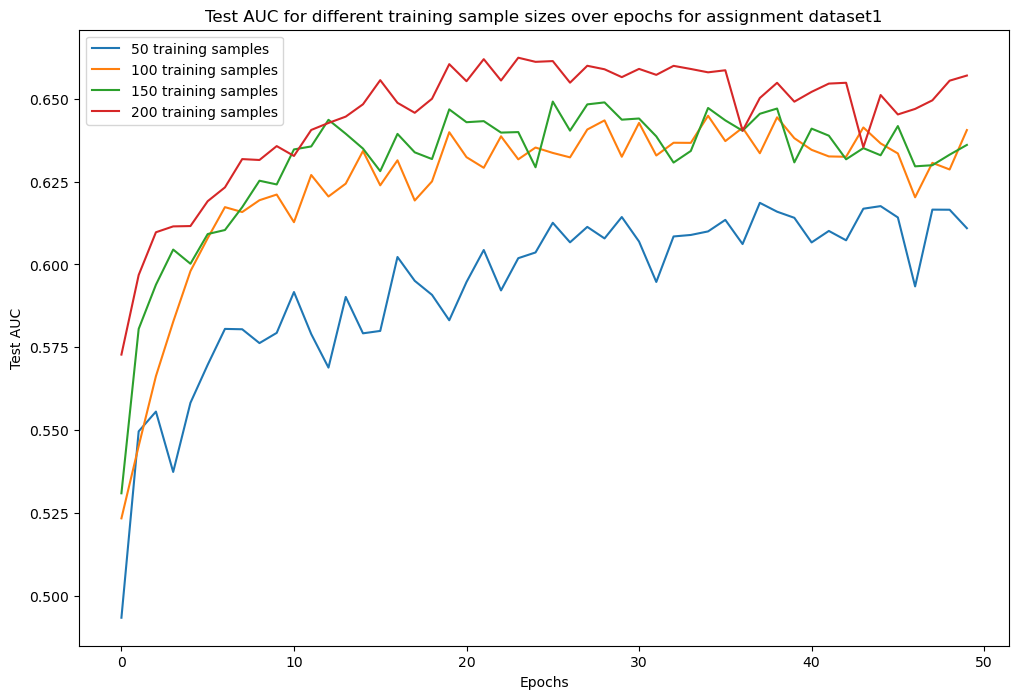

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# loop over each num_train_samples
for num_samples, aucs in auc_results.items():
    plt.plot(aucs, label=f"{num_samples} training samples")

plt.xlabel('Epochs')
plt.ylabel('Test AUC')
plt.legend()
plt.title('Test AUC for different training sample sizes over epochs for assignment dataset1')
plt.show()
